<a href="https://colab.research.google.com/github/yexf308/AppliedStatistics/blob/main/Case_Study_House_values_in_California.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%pylab inline 
import pandas as pd
from scipy import linalg
from itertools import combinations
import scipy
import sklearn
from sklearn.datasets import fetch_california_housing
np.random.seed(42)


Populating the interactive namespace from numpy and matplotlib


$\def\m#1{\mathbf{#1}}$
$\def\mm#1{\boldsymbol{#1}}$
$\def\mb#1{\mathbb{#1}}$
$\def\c#1{\mathcal{#1}}$
$\def\mr#1{\mathrm{#1}}$
$\newenvironment{rmat}{\left[\begin{array}{rrrrrrrrrrrrr}}{\end{array}\right]}$
$\newcommand\brm{\begin{rmat}}$
$\newcommand\erm{\end{rmat}}$
$\newenvironment{cmat}{\left[\begin{array}{ccccccccc}}{\end{array}\right]}$
$\newcommand\bcm{\begin{cmat}}$
$\newcommand\ecm{\end{cmat}}$


The notebook is based on Chap 2 of Hands on Machine Learning with Scikit Learn, Keras and TensorFlow, 3rd edition. 

**Your task** is to predict median house values in Californian districts, given a number of features from these districts.

## Download the data

In [2]:
!wget https://raw.githubusercontent.com/yexf308/AppliedStatistics/main/Data/housing.csv?raw=true -O housing.csv

--2022-08-29 15:03:01--  https://raw.githubusercontent.com/yexf308/AppliedStatistics/main/Data/housing.csv?raw=true
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1423529 (1.4M) [text/plain]
Saving to: ‘housing.csv’

housing.csv         100%[===================>]   1.36M  --.-KB/s    in 0.02s   

2022-08-29 15:03:01 (61.8 MB/s) - ‘housing.csv’ saved [1423529/1423529]



In [3]:
df = pd.read_csv('housing.csv')

## Take a quick look at the data

In [4]:
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


Some data types are float and one data type is object. 

In [6]:
df["ocean_proximity"].value_counts()


<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

In [7]:
df.describe()


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


We will separate the numerical data and objective data

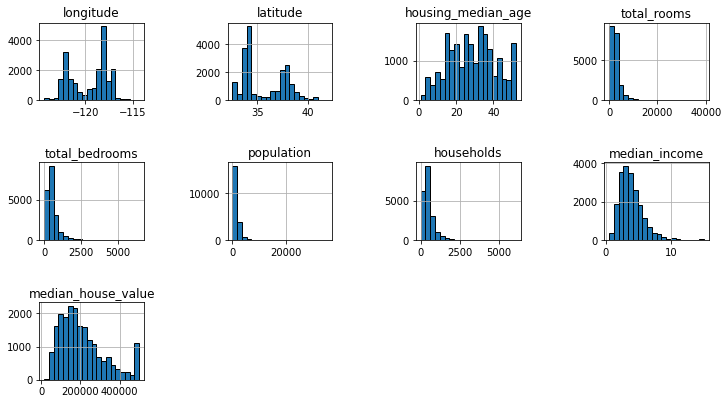

In [8]:
numerical_data = df.select_dtypes("number")
numerical_data.hist(bins=20, figsize=(12, 22), edgecolor="black",
                    layout=(9, 4))
plt.subplots_adjust(hspace=0.8, wspace=0.8)

- The median income attribute does not look like it is expressed in US dollars
(USD). After checking with the team that collected the data, you are told that the
data has been scaled and capped at 15 for higher median
incomes, and at 0.5 for lower median incomes. The numbers
represent roughly tens of thousands of dollars (e.g., 3 actually means about
$30,000).

- The housing median age and the median house value were also capped. The latter may be a serious problem since it is your target. Your
Machine Learning algorithms may learn that prices never go beyond that limit.

- These featuers have very different scales.

- Finally, many histograms are tail heavy: they extend much farther to the right of the median than to the left. Transform to bell shape is might be needed. 

These features are categorical. We can make some bar plot to see categories count for each feature.



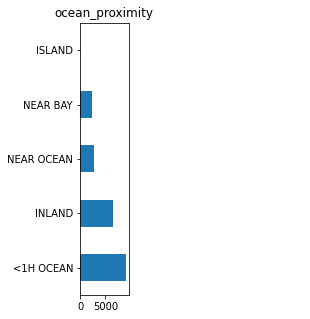

In [9]:
from math import ceil
from itertools import zip_longest

string_data = df.select_dtypes(object)


n_string_features = string_data.shape[1]
nrows, ncols = ceil(n_string_features / 4), 4

fig, axs = plt.subplots(ncols=ncols, nrows=nrows, figsize=(4, 5))

for feature_name, ax in zip_longest(string_data, axs.ravel()):
    if feature_name is None:
        # do not show the axis
        ax.axis("off")
        continue

    string_data[feature_name].value_counts().plot.barh(ax=ax)
    ax.set_title(feature_name)

#plt.subplots_adjust(hspace=0.2, wspace=0.8)

## Create a Test Set


In [10]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(df, test_size=0.2, random_state=42)

In [11]:
print(len(train_set))
print(len(test_set))

16512
4128


## Discover and Visualize the Data to Gain Insights
Make sure you have put the test set aside and you are only exploring the training
set. Also, if the training set is very large, you may want to sample an exploration
set, to make manipulations easy and fast during the exploration phase. In our case,
the training set is quite small, so we can just work directly on the full set.
### 1. Visualizing Geographical Data

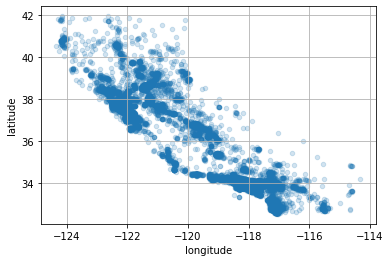

In [12]:
train_set.plot(kind="scatter", x="longitude", y="latitude", grid=True, alpha=0.2)
plt.show()
# with alpha=0.2 it is easier to visualize the places with high density of data points

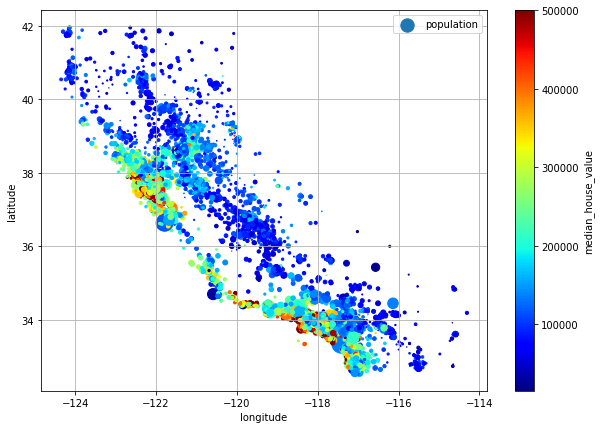

In [13]:
# we do better here. 
# The radius of each circle represents the district’s population (option s)
# The color represents the price (option c). 

train_set.plot(kind="scatter", x="longitude", y="latitude", grid=True,
             s=train_set["population"] / 100, label="population",
             c="median_house_value", cmap="jet", colorbar=True,
             legend=True, sharex=False, figsize=(10, 7))
plt.show()

This image tells you that the housing prices are very much related to the location
(e.g., close to the ocean) and to the population density, as you probably knew already.
A clustering algorithm should be useful for detecting the main cluster and for adding
new features that measure the proximity to the cluster centers.

### 2. Looking for Correlations
Compute the standard correlation
coefficient $\rho$ between every pair of attributes using the `corr()`
method. 


In [14]:
corr_matrix = train_set.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)


median_house_value    1.000000
median_income         0.687013
total_rooms           0.134060
housing_median_age    0.104714
households            0.065798
total_bedrooms        0.049993
population           -0.025820
longitude            -0.043603
latitude             -0.146324
Name: median_house_value, dtype: float64

Another way to check for correlation between attributes is to use the Pandas `scatter_matrix()` function

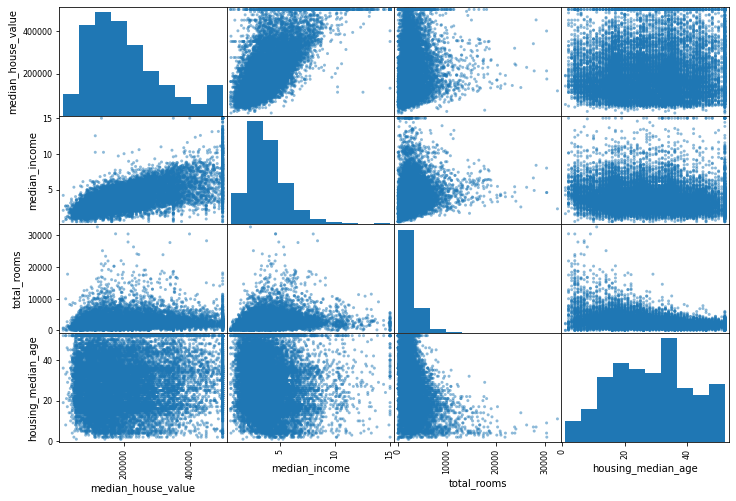

In [15]:
#from pandas.plotting import scatter_matrix

attributes = ["median_house_value", "median_income", "total_rooms",
              "housing_median_age"]
pd.plotting.scatter_matrix(train_set[attributes], figsize=(12, 8))
plt.show()

Looking at the correlation scatterplots, it seems like the most promising attribute
to predict the median house value is the median income, so let’s zoom in on their
scatterplot

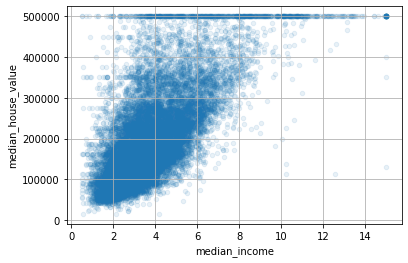

In [16]:
train_set.plot(kind="scatter", x="median_income", y="median_house_value",
             alpha=0.1, grid=True)
plt.show()

### Observation from correlation analysis
- The correlation is indeed quite strong; you can
clearly see the upward trend, and the points are not too dispersed.

- Some attributes have a skewed-right distribution, so you may want
to transform them (e.g., by computing their logarithm or square root).

- The price
cap that we noticed earlier is clearly visible as a horizontal line at \$ 500,000. But
this plot reveals other less obvious straight lines: a horizontal line around \$450,000,
another around \$350,000, perhaps one around \$280,000.



### 3. Experimenting with Attribute Combinations
We want to try out various attribute combinations. 

- The total number
of rooms in a district is not very useful if you don’t know how many households there are. What you really want is the number of rooms per household. 

- The total number of bedrooms by itself is not very useful. You probably want to compare
it to the number of rooms.

- The population per household also seems like an
interesting attribute combination to look at.

In [17]:
train_set["rooms_per_house"] = train_set["total_rooms"] / train_set["households"]
train_set["bedrooms_ratio"] = train_set["total_bedrooms"] / train_set["total_rooms"]
train_set["people_per_house"] = train_set["population"] / train_set["households"]

corr_matrix = train_set.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.687013
rooms_per_house       0.146940
total_rooms           0.134060
housing_median_age    0.104714
households            0.065798
total_bedrooms        0.049993
people_per_house     -0.021577
population           -0.025820
longitude            -0.043603
latitude             -0.146324
bedrooms_ratio       -0.254817
Name: median_house_value, dtype: float64

### Observation from Atribute combinations
- The new `bedrooms_ratio` feature is much more correlated with the
median house value than the total number of rooms or bedrooms. Apparently houses
with a lower bedroom/room ratio tend to be more expensive.

- The number of `rooms_per_house` is also more informative than the total number of rooms in a district. The larger the houses, the more expensive they are.

Obviously this exploration is not enough. But this cam quickly gain insights to get a reasonably good prototype. 

## Prepare Data
It is extremly important to prepare data before applying any machine learning algorithms. 

Note that `train_set.drop()` creates a copy of `train_set` without the column, it doesn't actually modify `train_set` itself, unless you pass `inplace=True`.

In [18]:
housing = train_set.drop("median_house_value", axis=1)
housing_labels = train_set["median_house_value"].copy()

### 1. Data Cleaning on numerical features
We saw earlier that the `total_bedrooms`
attribute has some missing values. 

- Option 1: Get rid of the corresponding districts.

- Option 2: Get rid of the whole feature.

- Option 3: Set the missing values to some value (zero, the mean, the median, etc.). This is
called **imputation**.

Let’s go for option 3 since it is the least destructive. 

In [19]:
null_rows_idx = housing.isnull().any(axis=1)
housing.loc[null_rows_idx].head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,rooms_per_house,bedrooms_ratio,people_per_house
9529,-118.31,33.94,40.0,1550.0,NaN,798.0,270.0,3.7750,<1H OCEAN,5.740741,NaN,2.955556
16519,-117.86,34.01,16.0,4632.0,NaN,3038.0,727.0,5.1762,<1H OCEAN,6.371389,NaN,4.178817
19782,-119.75,34.45,6.0,2864.0,NaN,1404.0,603.0,5.5073,NEAR OCEAN,4.749585,NaN,2.328358
1343,-120.32,37.29,38.0,576.0,NaN,478.0,112.0,2.3382,INLAND,5.142857,NaN,4.267857
9827,-121.85,36.61,38.0,238.0,NaN,191.0,67.0,1.3897,<1H OCEAN,3.552239,NaN,2.850746


In [20]:
#housing.dropna(subset=["total_bedrooms"], inplace=True)    # option 1

#housing.drop("total_bedrooms", axis=1)       # option 2

median = housing["total_bedrooms"].median()  # option 3
housing["total_bedrooms"].fillna(median, inplace=True)


We can use sklearn function `SimpleImputer`. 

- The benefit is that it will store
the median value of each feature: this will make it possible to impute missing values
not only on the training set, but also on the validation set, the test set, and any new
data fed to the model.

- Separating out the numerical attributes to use the "median" strategy (as it cannot be calculated on text attributes like `ocean_proximity`):



In [21]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy="median")
housing_num = housing.select_dtypes(include=[np.number])
imputer.fit(housing_num)


SimpleImputer(strategy='median')

In [22]:
print(imputer.statistics_)
print(housing_num.median().values)

[-1.18490000e+02  3.42500000e+01  2.90000000e+01  2.12900000e+03
  4.37000000e+02  1.16900000e+03  4.11000000e+02  3.52460000e+00
  5.23242240e+00  2.03058929e-01  2.81956622e+00]
[-1.18490000e+02  3.42500000e+01  2.90000000e+01  2.12900000e+03
  4.37000000e+02  1.16900000e+03  4.11000000e+02  3.52460000e+00
  5.23242240e+00  2.03058929e-01  2.81956622e+00]


Transform the training set:

In [23]:
X = imputer.transform(housing_num)
imputer.feature_names_in_
# X is a numpy array! has no column names nor index.
# so need to reconstruct dataframe


array(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       'rooms_per_house', 'bedrooms_ratio', 'people_per_house'],
      dtype=object)

In [24]:
housing_tr = pd.DataFrame(X, columns=housing_num.columns,
                          index=housing_num.index)
housing_tr.loc[null_rows_idx].head()


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,rooms_per_house,bedrooms_ratio,people_per_house
9529,-118.31,33.94,40.0,1550.0,437.0,798.0,270.0,3.7750,5.740741,0.203059,2.955556
16519,-117.86,34.01,16.0,4632.0,437.0,3038.0,727.0,5.1762,6.371389,0.203059,4.178817
19782,-119.75,34.45,6.0,2864.0,437.0,1404.0,603.0,5.5073,4.749585,0.203059,2.328358
1343,-120.32,37.29,38.0,576.0,437.0,478.0,112.0,2.3382,5.142857,0.203059,4.267857
9827,-121.85,36.61,38.0,238.0,437.0,191.0,67.0,1.3897,3.552239,0.203059,2.850746


Note Missing values can also be replaced with the mean value (`strategy="mean"`), or
with the most frequent value (`strategy="most_frequent"`), or with a constant
value (`strategy="constant", fill_value=…`). The last two strategies support nonnumerical data.

### (optional) Drop outliers
Sometimes you need to drop outliers. The function `IsolationForest` can be used to detect anomaly dataset.

In [25]:
from sklearn.ensemble import IsolationForest

isolation_forest = IsolationForest(random_state=42)
outlier_pred = isolation_forest.fit_predict(X)

In [26]:
sum(outlier_pred==-1)

1449

In [27]:
#housing = housing_tr.iloc[outlier_pred == 1]
#housing_labels = housing_labels.iloc[outlier_pred == 1]

## Handing text and categorical features
Here we only has one categorical feature: `ocean_proximity`. 

In [28]:
housing_cat = housing[["ocean_proximity"]]
housing_cat['ocean_proximity'].unique()

array(['NEAR OCEAN', 'NEAR BAY', '<1H OCEAN', 'INLAND', 'ISLAND'],
      dtype=object)

### 1. Convert to number
Let’s convert these categories from
text to numbers. We can use Scikit-Learn’s `OrdinalEncoder` class:

In [29]:
from sklearn.preprocessing import OrdinalEncoder
ordinal_encoder = OrdinalEncoder()
housing_cat_encoded = ordinal_encoder.fit_transform(housing_cat)

In [30]:
print(housing_cat.head(8))
print(housing_cat_encoded[:8])
print(ordinal_encoder.categories_)

      ocean_proximity
14196      NEAR OCEAN
8267       NEAR OCEAN
17445        NEAR BAY
14265       <1H OCEAN
2271           INLAND
17848        NEAR BAY
6252           INLAND
9389        <1H OCEAN
[[4.]
 [4.]
 [3.]
 [0.]
 [1.]
 [3.]
 [1.]
 [0.]]
[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
      dtype=object)]


### 2. One-hot embedding
Like we discussed in the class, under this representation our algorithm will assume nearby values are more similar with distant values. We can use one-hot encoding and this new feature is called dummy features. 

Note: this has some mathematical reasoning here, if we use 1D integer/real number to represent category, it natually comes with euclidean distance, however, we don't want to confuse with this since euclidean distance will a very bad measure here. 



In [31]:
from sklearn.preprocessing import OneHotEncoder
cat_encoder = OneHotEncoder()
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)
print(cat_encoder.categories_)

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
      dtype=object)]


In [32]:
housing_cat_1hot
# OneHotEncoder is a sparse matrix output

<16512x5 sparse matrix of type '<class 'numpy.float64'>'
	with 16512 stored elements in Compressed Sparse Row format>

In [33]:
housing_cat_1hot.toarray()
# You can force it to a dense numpy array

array([[0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 1., 0.],
       ...,
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.]])

If a categorial feature has a large number of categories, then one-hot encoding will create a large number of input features. One may replace the categorical input with numerical features related to the category. For example, replace `ocean_proximity` with distance to the ocean.  

## 3. Feature Scaling
Machine Learning algorithms don’t perform well when
the input numerical attributes have very different scales. Such as
- Total # of rooms ranges from 6 to 39320.
- Median incomes range from 0 to 15. 


### Min-max Scaling (Normalization)
For each feature, shift and rescale it such that they range from 0 to 1. You may also shift to $(-1,1)$ which is more preferable to neural networks. 

Note you should never use `fit()` and `fit_transform()` on anything else than the training set. Once you have a trained scaler, you can
then use it to `transform()` any other set. Then new data
contains outliers, these may end up scaled outside the range so one can clip it. 

In [34]:
from sklearn.preprocessing import MinMaxScaler
min_max_scaler = MinMaxScaler(feature_range=(-1, 1))
housing_num_min_max_scaled = min_max_scaler.fit_transform(housing_num)

### Standardization
Subtract the mean value and divide the result by the standard deviation. It is less affected by outliers. 

In [35]:
from sklearn.preprocessing import StandardScaler
std_scaler = StandardScaler()
housing_num_std_scaled = std_scaler.fit_transform(housing_num)

### Heavy Tail
For positive features with heavy tail, 
- replace with square root

- raise the feature to a power between 0 and 1. 

- replace with logarithm. 

- bucketizing the feature. 

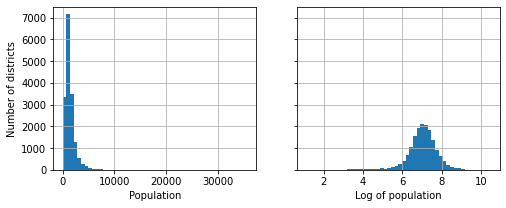

In [36]:
fig, axs = plt.subplots(1, 2, figsize=(8, 3), sharey=True)
housing["population"].hist(ax=axs[0], bins=50)
housing["population"].apply(np.log).hist(ax=axs[1], bins=50)
axs[0].set_xlabel("Population")
axs[1].set_xlabel("Log of population")
axs[0].set_ylabel("Number of districts")
plt.show()


### Multimodal distribution
When a feature has a multimodal distribution (i.e., with two or more clear peaks)

- Add a feature for
each of the modes (at least the main ones), representing the similarity between the housing median age and that particular mode.
The similarity measure is typically
computed using a Gaussian Radial Basis Function (RBF).


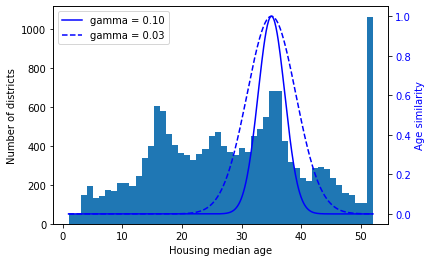

In [37]:
from sklearn.metrics.pairwise import rbf_kernel
ages = np.linspace(housing["housing_median_age"].min(),
                   housing["housing_median_age"].max(),
                   500).reshape(-1, 1)
gamma1 = 0.1
gamma2 = 0.03

age_simil_35 = rbf_kernel(ages, [[35]], gamma=gamma1)
rbf2 = rbf_kernel(ages, [[35]], gamma=gamma2)

fig, ax1 = plt.subplots()

ax1.set_xlabel("Housing median age")
ax1.set_ylabel("Number of districts")
ax1.hist(housing["housing_median_age"], bins=50)

ax2 = ax1.twinx()  # create a twin axis that shares the same x-axis
color = "blue"
ax2.plot(ages, age_simil_35, color=color, label="gamma = 0.10")
ax2.plot(ages, rbf2, color=color, label="gamma = 0.03", linestyle="--")
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_ylabel("Age similarity", color=color)

plt.legend(loc="upper left")
plt.show()

### Target value 
The target values may also need
to be transformed.

BUT don't forget to compute the inverse of transformers, and we can use `inverse_transform()` function. 

In [38]:
target_scaler = StandardScaler()
scaled_labels = target_scaler.fit_transform(housing_labels.to_frame())

In [39]:
# try some simple regression
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(housing[["median_income"]], scaled_labels)
some_new_data = housing[["median_income"]].iloc[:5] # pretend this is new data
scaled_predictions = model.predict(some_new_data)


In [40]:
predictions = target_scaler.inverse_transform(scaled_predictions)
# it is very important to inverse transform the targer_scaler. Otherwise your predictions are all wrong.

## 4. Custom Transformers
In practice, sklearn preprocessing is not enough. You will need to write
your own for tasks such as custom transformations, cleanup operations, or combining
specific features. For example, we can create a log-transformer and apply it to population feature. Here  `inverse_func` argument is optional.

In [41]:
from sklearn.preprocessing import FunctionTransformer

log_transformer = FunctionTransformer(np.log, inverse_func=np.exp)
log_pop = log_transformer.transform(housing[["population"]])

Your transformation function can take hyperparameters as additional arguments. For
example, here’s how to create a transformer that computes the same Gaussian RBF
similarity measure as earlier. 

In [42]:
rbf_transformer = FunctionTransformer(rbf_kernel, kw_args=dict(Y=[[35.]], gamma=0.1))
age_simil_35 = rbf_transformer.transform(housing[["housing_median_age"]])

If you pass it an array with
2 features, it will measure the 2D distance (Euclidean) to measure similarity. For
example, here’s how to add a feature that will measure the geographic similarity
between each district and San Francisco

In [43]:
sf_coords = 37.7749, -122.41
sf_transformer = FunctionTransformer(rbf_kernel, kw_args=dict(Y=[sf_coords], gamma=0.1))
sf_simil = sf_transformer.transform(housing[["latitude", "longitude"]])

Combine the feature to compute the ratio between the input features 0 and 1. 

In [44]:
ratio_transformer = FunctionTransformer(lambda X: X[:, [0]] / X[:, [1]])
ratio_transformer.transform(np.array([[1., 2.], [3., 4.]]))

array([[0.5 ],
       [0.75]])

A custom transformer can (and often does) use other estimators in its implementation.
For example, below we see a custom transformer that uses a `KMeans` clusterer
in the `fit()` method to identify the main clusters in the training data, and then uses
`rbf_kernel()` in the `transform()` method to measure how similar each sample is to
each cluster center

In [45]:
from sklearn.cluster import KMeans
from sklearn.base import BaseEstimator, TransformerMixin

class ClusterSimilarity(BaseEstimator, TransformerMixin):
    def __init__(self, n_clusters=10, gamma=1.0, random_state=None):
        self.n_clusters = n_clusters
        self.gamma = gamma
        self.random_state = random_state

    def fit(self, X, y=None, sample_weight=None):
        self.kmeans_ = KMeans(self.n_clusters, random_state=self.random_state)
        self.kmeans_.fit(X, sample_weight=sample_weight)
        return self  # always return self!

    def transform(self, X):
        return rbf_kernel(X, self.kmeans_.cluster_centers_, gamma=self.gamma)
    
    def get_feature_names_out(self, names=None):
        return [f"Cluster {i} similarity" for i in range(self.n_clusters)]


In [46]:
cluster_simil = ClusterSimilarity(n_clusters=10, gamma=1., random_state=42)
similarities = cluster_simil.fit_transform(housing[["latitude", "longitude"]],
                                           sample_weight=housing_labels)

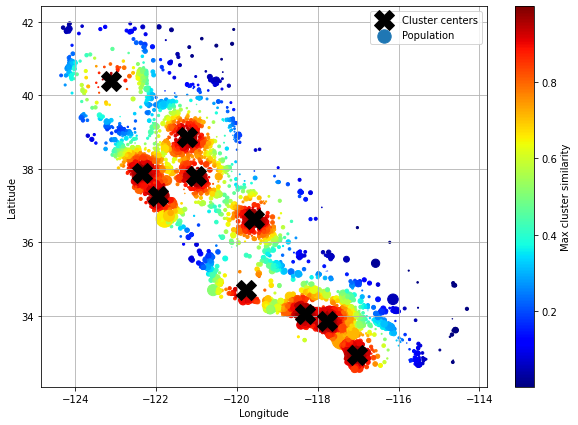

In [47]:

housing_renamed = housing.rename(columns={
    "latitude": "Latitude", "longitude": "Longitude",
    "population": "Population",
    "median_house_value": "Median house value (ᴜsᴅ)"})
housing_renamed["Max cluster similarity"] = similarities.max(axis=1)

housing_renamed.plot(kind="scatter", x="Longitude", y="Latitude", grid=True,
                     s=housing_renamed["Population"] / 100, label="Population",
                     c="Max cluster similarity",
                     cmap="jet", colorbar=True,
                     legend=True, sharex=False, figsize=(10, 7))
plt.plot(cluster_simil.kmeans_.cluster_centers_[:, 1],
         cluster_simil.kmeans_.cluster_centers_[:, 0],
         linestyle="", color="black", marker="X", markersize=20,
         label="Cluster centers")
plt.legend(loc="upper right")
plt.show()

How many it searches for is controlled by the `n_clusters` hyperparameter.
After training, the cluster centers are available via the `cluster_centers_` attribute.
The `fit()` method of KMeans supports an optional argument `sample_weight` which
lets the user specify the relative weights of the samples.

# Summary on data cleaning
- Missing values in numerical features will be imputed by replacing them with the median, as most ML algorithms don’t expect missing values. As for the categorical feature, any missing values will be replaced by the most frequent
category.

- The categorical feature will be one-hot encoded, as most ML algorithms only accept numerical inputs.

- A few ratio features will be computed and added: `bedrooms_ratio`,
`rooms_per_house` and `people_per_house`. Hopefully these will better correlate with the median housing value, and thereby help the ML models.

- A few cluster similarity features will also be added. These will likely be more useful to the model than latitude and longitude.

- Features with a long tail will be replaced by their logarithm, as most models prefer features with roughly uniform or Gaussian distributions.

- All numerical features will be standardized, as most ML algorithms prefer when all features have roughly the same scale.

## Pipelines (optional)
We can use `pipeline` to execute the data transformation steps in the right order automatically. Here the proposed method. You should refer to the textbook and sklearn for more information.

In [48]:
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_selector, make_column_transformer


In [49]:
# don't worry about this. 
def monkey_patch_get_signature_names_out():
    """Monkey patch some classes which did not handle get_feature_names_out()
       correctly in 1.0.0."""
    from inspect import Signature, signature, Parameter
    import pandas as pd
    from sklearn.impute import SimpleImputer
    from sklearn.pipeline import make_pipeline, Pipeline
    from sklearn.preprocessing import FunctionTransformer, StandardScaler

    default_get_feature_names_out = StandardScaler.get_feature_names_out

    if not hasattr(SimpleImputer, "get_feature_names_out"):
      print("Monkey-patching SimpleImputer.get_feature_names_out()")
      SimpleImputer.get_feature_names_out = default_get_feature_names_out

    if not hasattr(FunctionTransformer, "get_feature_names_out"):
        print("Monkey-patching FunctionTransformer.get_feature_names_out()")
        orig_init = FunctionTransformer.__init__
        orig_sig = signature(orig_init)

        def __init__(*args, feature_names_out=None, **kwargs):
            orig_sig.bind(*args, **kwargs)
            orig_init(*args, **kwargs)
            args[0].feature_names_out = feature_names_out

        __init__.__signature__ = Signature(
            list(signature(orig_init).parameters.values()) + [
                Parameter("feature_names_out", Parameter.KEYWORD_ONLY)])

        def get_feature_names_out(self, names=None):
            if self.feature_names_out is None:
                return default_get_feature_names_out(self, names)
            elif callable(self.feature_names_out):
                return self.feature_names_out(names)
            else:
                return self.feature_names_out

        FunctionTransformer.__init__ = __init__
        FunctionTransformer.get_feature_names_out = get_feature_names_out

monkey_patch_get_signature_names_out()

Monkey-patching SimpleImputer.get_feature_names_out()
Monkey-patching FunctionTransformer.get_feature_names_out()


In [50]:
def column_ratio(X):
  return X[:, [0]] / X[:, [1]]

def ratio_pipeline(name=None):
  return make_pipeline(
      SimpleImputer(strategy="median"),
      FunctionTransformer(column_ratio,
      feature_names_out=lambda input_features: [name]),
      StandardScaler())  
  

log_pipeline = make_pipeline(SimpleImputer(strategy="median"),
                            FunctionTransformer(np.log),
                            StandardScaler()) 

cluster_simil = ClusterSimilarity(n_clusters=10, gamma=1., random_state=42)

default_num_pipeline = make_pipeline(SimpleImputer(strategy="median"),
                                    StandardScaler()) 
cat_pipeline = make_pipeline(
    SimpleImputer(strategy="most_frequent"),
    OneHotEncoder(handle_unknown="ignore"))

preprocessing = ColumnTransformer([
        ("bedrooms_ratio", ratio_pipeline("bedrooms_ratio"),
                           ["total_bedrooms", "total_rooms"]),
        ("rooms_per_house", ratio_pipeline("rooms_per_house"),
                            ["total_rooms", "households"]),
        ("people_per_house", ratio_pipeline("people_per_house"),
                             ["population", "households"]),
        ("log", log_pipeline, ["total_bedrooms", "total_rooms",
                               "population", "households", "median_income"]),
        ("geo", cluster_simil, ["latitude", "longitude"]),
        ("cat", cat_pipeline, make_column_selector(dtype_include=object)),
        ("default", default_num_pipeline, ["housing_median_age"])
    ])  


#preprocessing = ColumnTransformer([
#        ("bedrooms_ratio", ratio_pipeline("bedrooms_ratio"),
#                           ["total_bedrooms", "total_rooms"]),
#        ("rooms_per_house", ratio_pipeline("rooms_per_house"),
#                            ["total_rooms", "households"]),
#        ("people_per_house", ratio_pipeline("people_per_house"),
#                             ["population", "households"]),
#        ("log", log_pipeline, ["total_bedrooms", "total_rooms",
#                               "population", "households", "median_income"]),
#        ("geo", cluster_simil, ["latitude", "longitude"]),
#        ("cat", cat_pipeline, make_column_selector(dtype_include=object)),
#    ],
#    remainder=default_num_pipeline)  # one column remaining: housing_median_age

In [51]:
housing_prepared = preprocessing.fit_transform(housing)
housing_prepared.shape

(16512, 24)

In [52]:
preprocessing.get_feature_names_out()

array(['bedrooms_ratio__bedrooms_ratio',
       'rooms_per_house__rooms_per_house',
       'people_per_house__people_per_house', 'log__total_bedrooms',
       'log__total_rooms', 'log__population', 'log__households',
       'log__median_income', 'geo__Cluster 0 similarity',
       'geo__Cluster 1 similarity', 'geo__Cluster 2 similarity',
       'geo__Cluster 3 similarity', 'geo__Cluster 4 similarity',
       'geo__Cluster 5 similarity', 'geo__Cluster 6 similarity',
       'geo__Cluster 7 similarity', 'geo__Cluster 8 similarity',
       'geo__Cluster 9 similarity', 'cat__ocean_proximity_<1H OCEAN',
       'cat__ocean_proximity_INLAND', 'cat__ocean_proximity_ISLAND',
       'cat__ocean_proximity_NEAR BAY', 'cat__ocean_proximity_NEAR OCEAN',
       'default__housing_median_age'], dtype=object)

# Select and Train a Model
You have cleaned up your data and are ready to select and train a machine learning model. 
### Linear Regression model

In [53]:
from sklearn.linear_model import LinearRegression

lin_reg = make_pipeline(preprocessing, LinearRegression())
lin_reg.fit(housing, housing_labels)



Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('bedrooms_ratio',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('functiontransformer',
                                                                   FunctionTransformer(feature_names_out=<function ratio_pipeline.<locals>.<lambda> at 0x7f5e1b0123b0>,
                                                                                       func=<function column_ratio at 0x7f5e1b012170>)),
                                                                  ('standardscaler',
                                                                   StandardScal...
                                                                   SimpleImputer(strategy='most_frequent')),
                                    

In [54]:
housing_predictions = lin_reg.predict(housing)
housing_predictions[:5].round(-2)  # -2 = rounded to the nearest hundred

array([262300., 198400., 277100., 282300.,  53900.])

In [55]:
housing_labels.iloc[:5].values


array([291000., 156100., 353900., 241200.,  53800.])

In [56]:
# or you can use the prepared data directly.
lr = LinearRegression()
lr.fit(housing_prepared, housing_labels.values)
housing_predictions2 = lr.predict(housing_prepared)
housing_predictions2[:5].round(-2)  # -2 = rounded to the nearest hundred

array([262300., 198400., 277100., 282300.,  53900.])

In [57]:
error_ratios = housing_predictions[:5].round(-2) / housing_labels.iloc[:5].values - 1
print(", ".join([f"{100 * ratio:.1f}%" for ratio in error_ratios]))

-9.9%, 27.1%, -21.7%, 17.0%, 0.2%


In [58]:
from sklearn.metrics import mean_squared_error

lin_rmse = mean_squared_error(housing_labels, housing_predictions,
                              squared=False)
lin_rmse

68865.79689251208

On average the prediction error on training set is $68865. 
### Decision Tree classifier



In [59]:
from sklearn.tree import DecisionTreeRegressor
tree_reg = DecisionTreeRegressor()
tree_reg.fit(housing_prepared, housing_labels.values)
housing_predictions = tree_reg.predict(housing_prepared)
tree_rmse = mean_squared_error(housing_labels.values, housing_predictions,
                              squared=False)
tree_rmse



0.0

On average the prediction error on the training set is $0. 

This is a clear sign of overfitting. 
## Better Evaluation Using Cross-Validation

In [60]:
from sklearn.model_selection import cross_val_score

tree_rmses = -cross_val_score(tree_reg, housing_prepared, housing_labels.values,
                              scoring="neg_root_mean_squared_error", cv=10)

In [61]:
pd.Series(tree_rmses).describe()


count       10.000000
mean     65658.327556
std       2678.456688
min      62573.591923
25%      63191.620996
50%      65761.986954
75%      67059.657449
max      69842.679282
dtype: float64

In [62]:
lin_rmses = -cross_val_score(lr, housing_prepared, housing_labels.values,
                              scoring="neg_root_mean_squared_error", cv=10)
pd.Series(lin_rmses).describe()

count       10.000000
mean     70679.177309
std       5542.511339
min      66609.048864
25%      68263.868551
50%      69190.776291
75%      70358.790590
max      85730.318553
dtype: float64

Decision Tree doesn’t look as good as it did earlier. Decision
Tree model seems to perform very slightly better than the linear model, but only
marginally better due to severe overfitting.

### Random Forest 
Random Forest training many Decision Trees on random subsets of
the features, then averaging out their predictions. Such models composed of many
other models are called ensembles: they are capable of boosting the performance of
the underlying model (in this case, Decision Trees)

**Warning:** it will take a few minutes.

In [63]:
from sklearn.ensemble import RandomForestRegressor
forest_reg = RandomForestRegressor()
forest_rmses = -cross_val_score(forest_reg, housing_prepared, housing_labels.values,
                                scoring="neg_root_mean_squared_error", cv=10)

In [64]:
pd.Series(forest_rmses).describe()


count       10.000000
mean     46659.230048
std       1087.449061
min      45260.974895
25%      45867.288820
50%      46532.341089
75%      47039.768285
max      48503.693789
dtype: float64

This is much better: Random Forests really look very promising. 

You can also try other different models, such as, SVM with different kernels, neural networks. 

# Fine-Tune Your Model
### Grid Search
Let’s assume that you now have a shortlist of promising models. You now need to fine-tune them. You can try to tune these hyperparameters manually, but this will be very tedius. 


In [65]:
from sklearn.model_selection import GridSearchCV

full_pipeline = Pipeline([
    ("preprocessing", preprocessing),
    ("random_forest", RandomForestRegressor(random_state=42)),
])
param_grid = [
    {'preprocessing__geo__n_clusters': [5, 8, 10],
     'random_forest__max_features': [4, 6, 8]},
    {'preprocessing__geo__n_clusters': [10, 15],
     'random_forest__max_features': [6, 8, 10]},
]
grid_search = GridSearchCV(full_pipeline, param_grid, cv=3,
                           scoring='neg_root_mean_squared_error')
grid_search.fit(housing, housing_labels)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(transformers=[('bedrooms_ratio',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('functiontransformer',
                                                                                          FunctionTransformer(feature_names_out=<function ratio_pipeline.<locals>.<lambda> at 0x7f5e1b0123b0>,
                                                                                                              func=<function column_ratio at 0x7f5e1b012170>)),
                                                                                         ('stan...
                                      

you can use Scikit-Learn’s `GridSearchCV` class to search for you. All you need
to do is tell it which hyperparameters you want it to experiment with and what values
to try out, and it will use cross-validation to evaluate all the possible combinations of hyperparameter values.

Here we search 9+6 combinations of hyperparameter values and it will train the pipeline 3 times per combination (3-fold CV). So it will be total of 45 rounds of training. 

when Scikit-Learn sees `preprocessing__geo__n_clusters`, it splits
this string at the double underscores, then it looks for an estimator named `preprocessing` inside the pipeline and finds the preprocessing `ColumnTransformer`. Then it looks for a transformer named `geo` inside this `ColumnTransformer` and
finds the `ClusterSimilarity` transformer we used on the latitude and longitude
attributes. The it finds this transformer’s `n_clusters` hyperparameter. Similarly,
`random_forest__max_features` refers to the `max_features` hyperparameter of the
estimator named `random_forest`, which is of course the RandomForest model

In [66]:
grid_search.best_params_

{'preprocessing__geo__n_clusters': 15, 'random_forest__max_features': 6}

In [67]:
cv_res = pd.DataFrame(grid_search.cv_results_)
cv_res.sort_values(by="mean_test_score", ascending=False, inplace=True)

# extra code – these few lines of code just make the DataFrame look nicer
cv_res = cv_res[["param_preprocessing__geo__n_clusters",
                 "param_random_forest__max_features", "split0_test_score",
                 "split1_test_score", "split2_test_score", "mean_test_score"]]
score_cols = ["split0", "split1", "split2", "mean_test_rmse"]
cv_res.columns = ["n_clusters", "max_features"] + score_cols
cv_res[score_cols] = -cv_res[score_cols].round().astype(np.int64)

cv_res.head()

,n_clusters,max_features,split0,split1,split2,mean_test_rmse
12,15,6,43718,44282,44074,44025
13,15,8,43815,44406,44313,44178
14,15,10,44357,44852,44818,44676
7,10,6,44658,45627,44926,45070
9,10,6,44658,45627,44926,45070


After this fine tuning, the RMSE is better than the score you got earilier (44025 vs 46659). 

### Randomized search 
If your hyperparameter search space is large, `RandomizedSearchCV` is preferable since gridsearch cost grows exponentially. It evaluates a fixed number of combinations, selecting a random value for each
hyperparameter at every iteration.

In [68]:
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingRandomSearchCV

These are other hyperparameter search classes:`HalvingRandom
SearchCV` and `HalvingGridSearchCV`. Some interesting statistical tools are available here as well. 

In [69]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

param_distribs = {'preprocessing__geo__n_clusters': randint(low=3, high=50),
                  'random_forest__max_features': randint(low=2, high=20)}

rnd_search = RandomizedSearchCV(
    full_pipeline, param_distributions=param_distribs, n_iter=10, cv=3,
    scoring='neg_root_mean_squared_error', random_state=42)

rnd_search.fit(housing, housing_labels)

RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('preprocessing',
                                              ColumnTransformer(transformers=[('bedrooms_ratio',
                                                                               Pipeline(steps=[('simpleimputer',
                                                                                                SimpleImputer(strategy='median')),
                                                                                               ('functiontransformer',
                                                                                                FunctionTransformer(feature_names_out=<function ratio_pipeline.<locals>.<lambda> at 0x7f5e1b0123b0>,
                                                                                                                    func=<function column_ratio at 0x7f5e1b012170>)),...
                                                                               ['housi

In [70]:
cv_res = pd.DataFrame(rnd_search.cv_results_)
cv_res.sort_values(by="mean_test_score", ascending=False, inplace=True)
cv_res = cv_res[["param_preprocessing__geo__n_clusters",
                 "param_random_forest__max_features", "split0_test_score",
                 "split1_test_score", "split2_test_score", "mean_test_score"]]
cv_res.columns = ["n_clusters", "max_features"] + score_cols
cv_res[score_cols] = -cv_res[score_cols].round().astype(np.int64)
cv_res.head()

,n_clusters,max_features,split0,split1,split2,mean_test_rmse
1,45,9,41393,42079,42347,41939
8,32,7,41998,42548,42747,42431
5,42,4,41913,42659,43208,42593
0,41,16,42456,42858,43361,42892
2,23,8,42557,43379,43523,43153


This time is even better! The RMSE is 41939 vs 44025 (in grid search). 

How to choose the sampling distribution for a hyperparameter.

- `scipy.stats.randint(a, b+1)`: for hyperparameters with discrete values that range from $a$ to $b$, and all values in that range seem equally likely.

- `scipy.stats.uniform(a, b)`: this is very similar, but for continuous hyperparameters.

- `scipy.stats.geom(1 / scale)`: for discrete values, when you want to sample roughly in a given scale. E.g., with scale=1000 most samples will be in this ballpark, but $~10\%$ of all samples will be $< 100$ and $~10\%$ will be $>2300$.

- `scipy.stats.expon(scale)`: this is the continuous equivalent of geom. Just set scale to the most likely value.

- `scipy.stats.reciprocal(a, b)`: when you have almost no idea what the optimal hyperparameter value's scale is. If you set $a=0.01$ and $b=100$, then you're just as likely to sample a value between $0.01$ and $0.1$ as a value between $10$ and $100$.

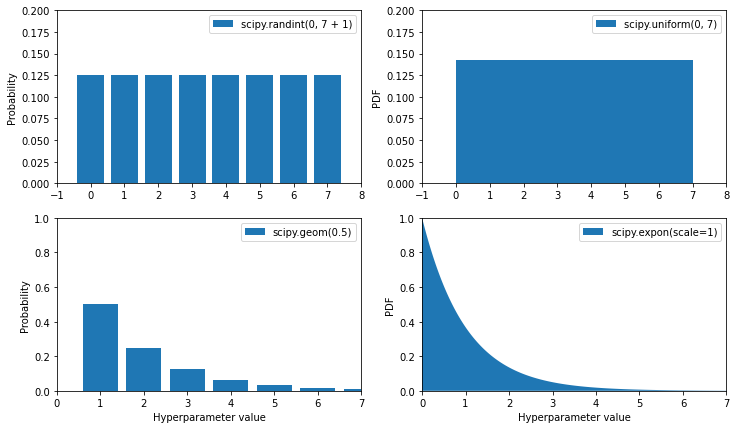

In [71]:
from scipy.stats import randint, uniform, geom, expon

xs1 = np.arange(0, 7 + 1)
randint_distrib = randint(0, 7 + 1).pmf(xs1)

xs2 = np.linspace(0, 7, 500)
uniform_distrib = uniform(0, 7).pdf(xs2)

xs3 = np.arange(0, 7 + 1)
geom_distrib = geom(0.5).pmf(xs3)

xs4 = np.linspace(0, 7, 500)
expon_distrib = expon(scale=1).pdf(xs4)

plt.figure(figsize=(12, 7))

plt.subplot(2, 2, 1)
plt.bar(xs1, randint_distrib, label="scipy.randint(0, 7 + 1)")
plt.ylabel("Probability")
plt.legend()
plt.axis([-1, 8, 0, 0.2])

plt.subplot(2, 2, 2)
plt.fill_between(xs2, uniform_distrib, label="scipy.uniform(0, 7)")
plt.ylabel("PDF")
plt.legend()
plt.axis([-1, 8, 0, 0.2])

plt.subplot(2, 2, 3)
plt.bar(xs3, geom_distrib, label="scipy.geom(0.5)")
plt.xlabel("Hyperparameter value")
plt.ylabel("Probability")
plt.legend()
plt.axis([0, 7, 0, 1])

plt.subplot(2, 2, 4)
plt.fill_between(xs4, expon_distrib, label="scipy.expon(scale=1)")
plt.xlabel("Hyperparameter value")
plt.ylabel("PDF")
plt.legend()
plt.axis([0, 7, 0, 1])

plt.show()


### Analyze the Best Models and Their Errors
You will often gain good insights on the problem by inspecting the best models. For
example, the `RandomForestRegressor` can indicate the relative importance of each
attribute for making accurate predictions:



In [72]:
final_model = rnd_search.best_estimator_  # includes preprocessing
feature_importances = final_model["random_forest"].feature_importances_

In [74]:
feature_importances.round(3)

array([0.074, 0.052, 0.045, 0.007, 0.007, 0.007, 0.007, 0.187, 0.012,
       0.014, 0.041, 0.01 , 0.006, 0.006, 0.021, 0.016, 0.01 , 0.013,
       0.01 , 0.01 , 0.025, 0.013, 0.003, 0.005, 0.009, 0.004, 0.015,
       0.011, 0.005, 0.012, 0.007, 0.011, 0.011, 0.004, 0.008, 0.009,
       0.007, 0.016, 0.008, 0.012, 0.008, 0.011, 0.01 , 0.011, 0.024,
       0.011, 0.01 , 0.01 , 0.013, 0.023, 0.01 , 0.005, 0.008, 0.004,
       0.081, 0.   , 0.   , 0.003, 0.011])

In [75]:
sorted(zip(feature_importances,
           final_model["preprocessing"].get_feature_names_out()),
           reverse=True)

[(0.18658914478653787, 'log__median_income'),
 (0.08078603604072165, 'cat__ocean_proximity_INLAND'),
 (0.0736515117226182, 'bedrooms_ratio__bedrooms_ratio'),
 (0.051697179886742106, 'rooms_per_house__rooms_per_house'),
 (0.04467544232665202, 'people_per_house__people_per_house'),
 (0.040569125036286104, 'geo__Cluster 2 similarity'),
 (0.024707343640146137, 'geo__Cluster 12 similarity'),
 (0.02437900146527174, 'geo__Cluster 36 similarity'),
 (0.02259582389708218, 'geo__Cluster 41 similarity'),
 (0.020706363357609944, 'geo__Cluster 6 similarity'),
 (0.016288877164873577, 'geo__Cluster 7 similarity'),
 (0.015663527625441, 'geo__Cluster 29 similarity'),
 (0.015317959335675101, 'geo__Cluster 18 similarity'),
 (0.013821741771541378, 'geo__Cluster 1 similarity'),
 (0.013408962423244283, 'geo__Cluster 13 similarity'),
 (0.013202182869681492, 'geo__Cluster 40 similarity'),
 (0.012931545115635244, 'geo__Cluster 9 similarity'),
 (0.012320008527059882, 'geo__Cluster 0 similarity'),
 (0.01224483296

With this information, you may want to try dropping some of the less useful features
(e.g., apparently only one `ocean_proximity` category is really useful, so you could try
dropping the others).

# Evaluate on test set
You are ready to evaluate the final model on the test set.

In [76]:
X_test = test_set.drop("median_house_value", axis=1)
y_test = test_set["median_house_value"].copy()

final_predictions = final_model.predict(X_test)

final_rmse = mean_squared_error(y_test, final_predictions, squared=False)
print(final_rmse)

42186.66329198852


We can compute a $95\%$ confidence interval for the test RMSE:



In [77]:
from scipy import stats

confidence = 0.95
squared_errors = (final_predictions - y_test) ** 2
np.sqrt(stats.t.interval(confidence, len(squared_errors) - 1,
                         loc=squared_errors.mean(),
                         scale=stats.sem(squared_errors)))

array([39917.41313259, 44339.92837416])